In [2]:
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F

from sklearn import datasets
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
import os

# --- configuration --- #
BATCH_SIZE = 1000
LOG_INTERVAL = 5
EPOCHS = 3
INPUT_DIM = 100
OUTPUT_DIM = 100
HIDDEN_DIM = 200
SAVE_PLT_INTERVAL = 10
N_COUPLE_LAYERS = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#--- loss function ---#
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    s=torch.var(x-y)
    #s=0.05
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [s, 1.5*s, 2*s, 3*s]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [s]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

def MMD1(x, y, kernel, bandwidth_range):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    s=torch.var(x-y)
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "rbf":


        for C,a in bandwidth_range:
            XX += C**a * ((C + dxx) / a)**-a
            YY += C**a * ((C + dyy) / a)**-a
            XY += C**a * ((C + dxy) / a)**-a

    if kernel == "m":

        bandwidth_range = [0.2, 1.5,3.0]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)
def MMDout(x,y,kernel):
    bandwidth_range = [(0.01, 2), (0.1, 2), (1., 2)]
    return MMD1(x,y,kernel,bandwidth_range)

def MMDin(x,y,kernel):
    bandwidth_range = [(0.1, 2), (1., 2), (10, 2)]
    return MMD1(x,y,kernel,bandwidth_range)
# --- model --- #
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.mask = mask.to(device)
        nn.init.xavier_uniform_(self.s_fc1.weight)
        nn.init.xavier_uniform_(self.s_fc2.weight)
        nn.init.xavier_uniform_(self.s_fc3.weight)
        nn.init.xavier_uniform_(self.t_fc1.weight)
        nn.init.xavier_uniform_(self.t_fc2.weight)
        nn.init.xavier_uniform_(self.t_fc3.weight)
    def forward(self, x):
        x_m =self.mask * x.to(device)
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian
    # we define the global backward mapping for our neural network
    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x
class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for i in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0 # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
        return x, ldj_sum
# we define the global backward mapping for our neural network
    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z


def mask1(n,rand=3):
#n = 1000  # number of elements of the mask
    half = n // 2

    tensor = torch.cat((torch.ones(half), torch.zeros(n - half)))
    if rand==1:
        index = torch.randperm(tensor.size(0))
        shuffled_tensor = tensor[index]
        return shuffled_tensor
    elif rand==2:
        return tensor
    else:
        tensor = torch.zeros(n)
        tensor[::2] = 1
        return tensor
def symetricmatrix(N):
    S=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            if i==j:
                S[i][j]=1
            elif i>j:
                S[i][j]=(N-i+j)/(N)
                S[j][i]=(N-i+j)/(N)
            else:
                continue
    return S


#samplesize = 250 #sample of the variables alpha, beta and gammas
def sample_dag(samplesize, alphaave, betaave,positive=False):
    sample = distributions.MultivariateNormal(torch.Tensor([alphaave,betaave]), torch.eye(2)*0.05).sample((samplesize,))
    sampledag = torch.permute(sample,(1,0))
    alpha = sampledag[0]
    beta = sampledag[1]
    if positive:
      for elemtn in alpha:
          if elemtn<0:
              alpha, beta = sample_dag(samplesize, alphaave, betaave)
  #            print(elemtn)
              break
    return alpha, beta

def betaave(a,b,n):
    xx = torch.linspace(0, 1, steps=n)
    return torch.pow(xx,a)*torch.pow(1-xx,b)/sc.beta(a+1,b+1),xx

# --- Ansatz --- #
def betadist(alpha,beta,N):
    xx = torch.linspace(0.001, 1, steps=N)
    #fabx=torch.pow(xx,alpha[0])*torch.pow(1-xx,beta[0])
    fabx=[]
    for i in range(torch.numel(alpha)):
        for j in range(torch.numel(beta)):
            ff=torch.pow(xx,alpha[i])*torch.pow(1-xx,beta[j])/sc.beta(torch.Tensor.numpy(alpha[i]+1), torch.Tensor.numpy(beta[j]+1))
            fabx.append(ff)
    return torch.stack(fabx)

# This generates a symetric matrix but only for the first points but is not the one me want
def gaussiankernelmat(Mean,sig):
    N=Mean.size(0)
    S=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            if i==j:
                S[i][j]=torch.exp(-torch.tensor((i-j)**2/(2*sig*sig)))
            elif i>j:
                S[i][j]=torch.exp(-torch.tensor((i-j)**2/(2*sig*sig)))
                S[j][i]=torch.exp(-torch.tensor((i-j)**2/(2*sig*sig)))
            else:
                continue
    return S

def I0(a,b,nu):
    if nu==0:
        return b-a
    else:
        return (torch.sin(nu*b)-torch.sin(nu*a))/nu
def I1(a,b,nu):
    if nu==0:
        return (b*b-a*a)/2
    else:
        return (b*torch.sin(nu*b)-a*torch.sin(nu*a))/nu+(torch.cos(nu*b)-torch.cos(nu*a))/(nu*nu)
def Qnu(x,numax,nusteps):
    nu= torch.linspace(0, numax, steps=nusteps)
    C=torch.zeros(torch.numel(nu), torch.numel(x))
    for l in range(torch.numel(nu)):
        for k in range(torch.numel(x)):
            if k==0:
                C[l][k]=(x[k+1]*I0(x[k],x[k+1],nu[l])-I1(x[k],x[k+1],nu[l]))/(x[k+1]-x[k])
                #continue
            elif k==torch.numel(x)-1:
                C[l][k]=(I1(x[k-1],x[k],nu[l])-x[k-1]*I0(x[k-1],x[k],nu[l]))/(x[k]-x[k-1])
                #continue
            elif k>1:
                C[l][k]=(x[k+1]*I0(x[k],x[k+1],nu[l])-I1(x[k],x[k+1],nu[l]))/(x[k+1]-x[k]) + (I1(x[k-1],x[k],nu[l])-x[k-1]*I0(x[k-1],x[k],nu[l]))/(x[k]-x[k-1])
                #continue
    return C



In [ ]:
def createdata(a,b,Nab,Nx,Nnu):
    alpha01,beta01=sample_dag(Nab, a, b, False)
    fabx1=betadist(alpha01,beta01,Nx)
    C1=Qnu(torch.linspace(0, 1, steps=Nx),10,Nnu)
    Qdata=torch.matmul(C1,fabx1.transpose(0,1))
    output_data1 = prior_z.sample((Qdata.size(1),)).transpose(1,0)
    c=torch.cat((Qdata,output_data1),0)
#    model.eval()
#    Qnu1, logdet1 =model(fabx1)
#    z1_12, z1_88 = torch.split(Qnu1.detach().transpose(1,0), [12, 88])
#    x1=model.backward(c.transpose(1,0)).detach()
    return fabx1,c.transpose(1,0)

samplesize=200
alpha, beta = sample_dag(samplesize, 0.7, 3,True)

Nx=INPUT_DIM # Number of points in the x axis and input of the neural network
fabx=betadist(alpha,beta,Nx)
fabave, xx=betaave(0.7,3,100)
fabx2d=torch.transpose(fabx,0,1)[45].reshape(samplesize,samplesize)

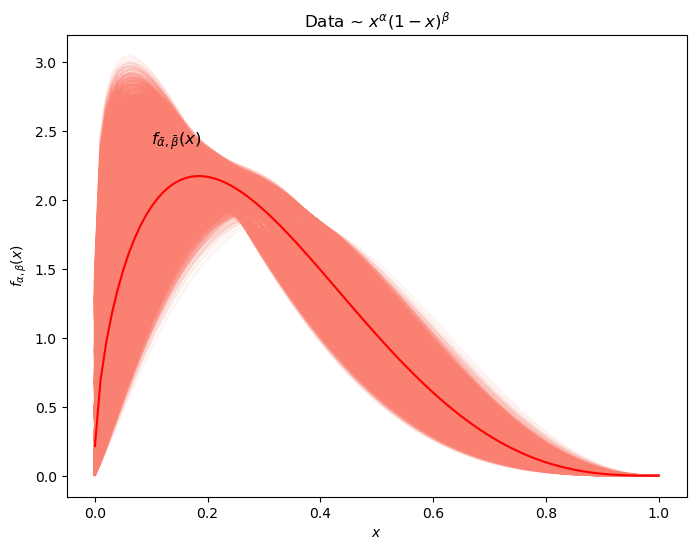

In [4]:
#plt.hist(torch.Tensor.numpy(fabx[0]), bins=20)
#plt.hist(torch.Tensor.numpy(torch.transpose(fabx,0,1)[190]), bins=70)
#plt.hist(torch.Tensor.numpy(mi), bins=70)
#plt.imshow(fabx2d, cmap='viridis')
xaxis=np.linspace(0, 1, Nx)
plt.figure(figsize=(8,6))
for i in range(10000):
    plt.plot(xaxis,fabx[i+5000],color='salmon',alpha=0.1)
plt.plot(xaxis,torch.mean(fabx,0),color='red')
plt.text(0.1, 2.4, r'$f_{\bar{\alpha},\bar{\beta}}(x)$', fontsize=12)
plt.xlabel(r'$x$')
#axis limits
#plt.ylim(0, 10)
plt.ylabel(r'$f_{\alpha,\beta}(x)$')
plt.title(r'Data ~ $x^{\alpha}(1-x)^{\beta}$')

plt.show()

In [5]:
Nnu=12
C=Qnu(torch.linspace(0, 1, steps=Nx),10,Nnu)
Q_nu=torch.matmul(C,fabx.transpose(0,1))
Q_nuave=torch.matmul(C,fabave)

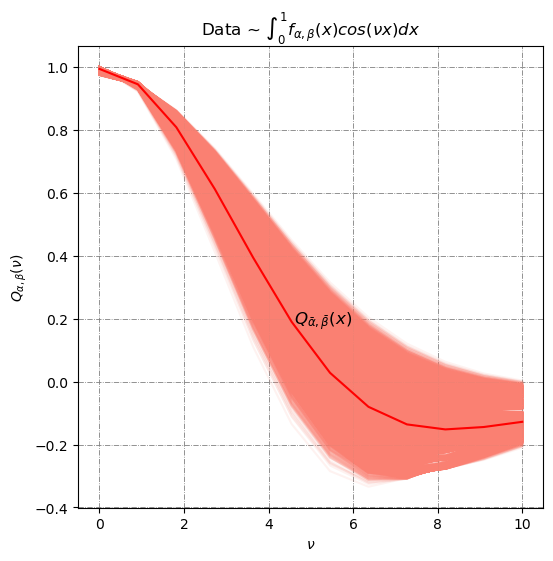

In [6]:
nu= torch.linspace(0, 10, steps=Nnu)
plt.figure(figsize=(6,6))
#plot with  red pastel color
for i in range(10000):
    plt.plot(nu,Q_nu[:,i],color='salmon',alpha=0.1)
plt.plot(nu,torch.mean(Q_nu,1),color='red')
plt.text(4.6, .18, r'$Q_{\bar{\alpha},\bar{\beta}}(x)$', fontsize=12)
plt.xlabel(r'$\nu$')
plt.ylabel(r'$Q_{\alpha,\beta}(\nu)$')
plt.title(r'Data ~ $\int_0^1 f_{\alpha,\beta}(x)cos(\nu x) dx$')
plt.grid(True, color = "grey", linewidth = ".6", linestyle = "-.")
#plt.plot(Q_nu[:,1])  # Works now
plt.show()